In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-02 10:16:45.065804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from PIL import Image, ImageDraw, ImageFont
font_path = '../dados/targa/Targa.ttf'

In [4]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [5]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [6]:
vocab = np.unique(list(df['txt_content'].sum()) + ["]"])
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']'],
      dtype='<U1')

In [7]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [9]:
autoencoder = tf.keras.models.load_model('model_MSE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier = tf.keras.models.load_model('classifier_pre_trained.tf')

In [10]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [11]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)

  num_classes = len(vocab)
  char_to_index = {char: idx for idx, char in enumerate(vocab)}
  images = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  images = np.array(images)
  images = np.expand_dims(images, axis=-1)
  images = images.astype('float32') / 255.
  images = autoencoder.predict(images)

  X = []
  Y = []

  for i,text in enumerate(df['txt_content']):
    x = images[i]    
    interval = [0, 25, 50, 75, 100, 125, 150, 175]  # Adjusted intervals for 7 parts
    for i in range(len(interval)-1):
        fake_img = x[:,interval[i]:interval[i+1]]
        y = np.zeros((1,num_classes))
        y[0,char_to_index[text[i]]] = 1
        X.append(fake_img)
        Y.append(y)

  X = np.array(X)
  Y = np.array(Y)

  X = X.reshape(-1,50,25,1)
  Y = Y.reshape(-1,num_classes)
  return X,Y,images

X,Y,images = generate_X_Y('../dados/CAPTCHA-10k/treinamento')

2024-08-02 10:17:05.406830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


250/250 [==============================] - 8s 25ms/step


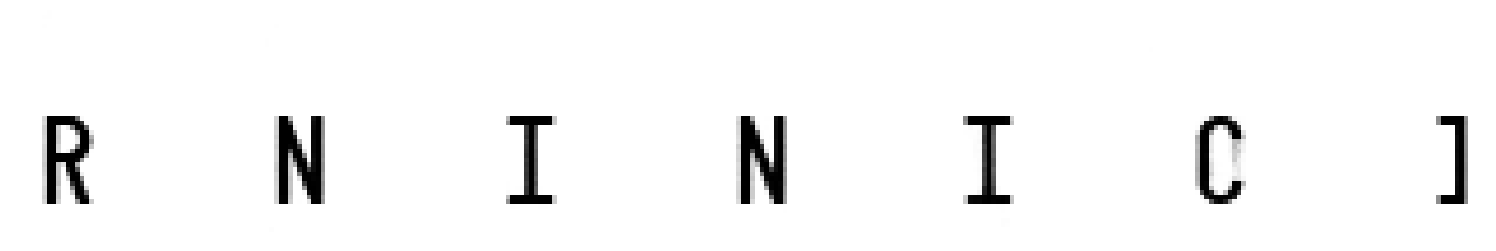

In [12]:
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
for i in range(7):
    axes[i].imshow(X[i].reshape(50, 25), cmap='gray')
    axes[i].axis('off')
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X)
batch_size = 8
augmented_data_generator = datagen.flow(X, Y, batch_size=batch_size)

In [14]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') == 1.0:
            print("\nReached 100% accuracy, stopping training!")
            self.model.stop_training = True
        
        if logs.get('val_accuracy') == 1.0:
            print("\nReached 100% accuracy on val, stopping training!")
            self.model.stop_training = True

checkpoint = ModelCheckpoint(
    'classifier_full_trained_best.tf',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [15]:
stop_training_callback = StopTrainingCallback()
classifier.fit(augmented_data_generator,steps_per_epoch=len(X) // batch_size, epochs=500, 
               callbacks=[stop_training_callback,checkpoint],
               validation_data=(X, Y))

Epoch 1/500


2024-08-02 10:17:15.288191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-02 10:17:15.308630: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x762650bb83c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 10:17:15.308668: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-02 10:17:15.312714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 10:17:15.424735: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6996/7000 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9706
Epoch 1: val_accuracy improved from -inf to 0.97630, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 45s 6ms/step - loss: 0.1580 - accuracy: 0.9706 - val_loss: 0.1238 - val_accuracy: 0.9763
Epoch 2/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9734
Epoch 2: val_accuracy did not improve from 0.97630
7000/7000 [==============================] - 39s 6ms/step - loss: 0.1294 - accuracy: 0.9734 - val_loss: 0.1235 - val_accuracy: 0.9747
Epoch 3/500
6995/7000 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9739
Epoch 3: val_accuracy improved from 0.97630 to 0.97643, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 39s 6ms/step - loss: 0.1220 - accuracy: 0.9739 - val_loss: 0.1054 - val_accuracy: 0.9764
Epoch 4/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.1178 - accuracy: 0.9751
Epoch 4: val_accuracy did not improve from 0.97643
7000/7000 [==============================] - 39s 6ms/step - loss: 0.1179 - accuracy: 0.9751 - val_loss: 0.1105 - val_accuracy: 0.9761
Epoch 5/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9752
Epoch 5: val_accuracy improved from 0.97643 to 0.97804, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.1118 - accuracy: 0.9752 - val_loss: 0.0974 - val_accuracy: 0.9780
Epoch 6/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9763
Epoch 6: val_accuracy did not improve from 0.97804
7000/7000 [==============================] - 38s 5ms/step - loss: 0.1101 - accuracy: 0.9763 - val_loss: 0.1104 - val_accuracy: 0.9766
Epoch 7/500
6990/7000 [============================>.] - ETA: 0s - loss: 0.1079 - accuracy: 0.9757
Epoch 7: val_accuracy improved from 0.97804 to 0.97918, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 39s 6ms/step - loss: 0.1078 - accuracy: 0.9758 - val_loss: 0.0944 - val_accuracy: 0.9792
Epoch 8/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9765
Epoch 8: val_accuracy improved from 0.97918 to 0.97936, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 39s 6ms/step - loss: 0.1057 - accuracy: 0.9765 - val_loss: 0.0896 - val_accuracy: 0.9794
Epoch 9/500
6990/7000 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9767
Epoch 9: val_accuracy did not improve from 0.97936
7000/7000 [==============================] - 38s 5ms/step - loss: 0.1041 - accuracy: 0.9767 - val_loss: 0.0933 - val_accuracy: 0.9786
Epoch 10/500
7000/7000 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9771
Epoch 10: val_accuracy did not improve from 0.97936
7000/7000 [==============================] - 37s 5ms/step - loss: 0.1027 - accuracy: 0.9771 - val_loss: 0.1030 - val_accuracy: 0.9771
Epoch 11/500
6992/7000 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9778
Epoch 11: val_accuracy improved from 0.97936 to 0.97962, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.1017 - accuracy: 0.9778 - val_loss: 0.0897 - val_accuracy: 0.9796
Epoch 12/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9776
Epoch 12: val_accuracy improved from 0.97962 to 0.98018, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 44s 6ms/step - loss: 0.1013 - accuracy: 0.9776 - val_loss: 0.0866 - val_accuracy: 0.9802
Epoch 13/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9777
Epoch 13: val_accuracy did not improve from 0.98018
7000/7000 [==============================] - 49s 7ms/step - loss: 0.0976 - accuracy: 0.9777 - val_loss: 0.0898 - val_accuracy: 0.9792
Epoch 14/500
6998/7000 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9775
Epoch 14: val_accuracy did not improve from 0.98018
7000/7000 [==============================] - 44s 6ms/step - loss: 0.0998 - accuracy: 0.9775 - val_loss: 0.0911 - val_accuracy: 0.9792
Epoch 15/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9779
Epoch 15: val_accuracy did not improve from 0.98018
7000/7000 [==============================] - 43s 6ms/step - loss: 0.0970 - accuracy: 0.9780 - val_loss: 0.0880 - val_accuracy: 0.9797
Epoch 16

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 42s 6ms/step - loss: 0.0949 - accuracy: 0.9779 - val_loss: 0.0889 - val_accuracy: 0.9802
Epoch 20/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9785
Epoch 20: val_accuracy did not improve from 0.98021
7000/7000 [==============================] - 41s 6ms/step - loss: 0.0946 - accuracy: 0.9785 - val_loss: 0.0882 - val_accuracy: 0.9800
Epoch 21/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9782
Epoch 21: val_accuracy did not improve from 0.98021
7000/7000 [==============================] - 41s 6ms/step - loss: 0.0950 - accuracy: 0.9783 - val_loss: 0.0820 - val_accuracy: 0.9801
Epoch 22/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9785
Epoch 22: val_accuracy did not improve from 0.98021
7000/7000 [==============================] - 40s 6ms/step - loss: 0.0931 - accuracy: 0.9785 - val_loss: 0.0967 - val_accuracy: 0.9787
Epoch 23

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 42s 6ms/step - loss: 0.0923 - accuracy: 0.9783 - val_loss: 0.0845 - val_accuracy: 0.9805
Epoch 29/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9789
Epoch 29: val_accuracy did not improve from 0.98048
7000/7000 [==============================] - 40s 6ms/step - loss: 0.0910 - accuracy: 0.9790 - val_loss: 0.0883 - val_accuracy: 0.9804
Epoch 30/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9792
Epoch 30: val_accuracy did not improve from 0.98048
7000/7000 [==============================] - 40s 6ms/step - loss: 0.0901 - accuracy: 0.9792 - val_loss: 0.0828 - val_accuracy: 0.9804
Epoch 31/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9791
Epoch 31: val_accuracy improved from 0.98048 to 0.98088, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 42s 6ms/step - loss: 0.0906 - accuracy: 0.9791 - val_loss: 0.0824 - val_accuracy: 0.9809
Epoch 32/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9794
Epoch 32: val_accuracy did not improve from 0.98088
7000/7000 [==============================] - 41s 6ms/step - loss: 0.0896 - accuracy: 0.9794 - val_loss: 0.0884 - val_accuracy: 0.9803
Epoch 33/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9797
Epoch 33: val_accuracy improved from 0.98088 to 0.98095, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 42s 6ms/step - loss: 0.0883 - accuracy: 0.9797 - val_loss: 0.0836 - val_accuracy: 0.9809
Epoch 34/500
6991/7000 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9796
Epoch 34: val_accuracy did not improve from 0.98095
7000/7000 [==============================] - 40s 6ms/step - loss: 0.0884 - accuracy: 0.9796 - val_loss: 0.0830 - val_accuracy: 0.9805
Epoch 35/500
6992/7000 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9788
Epoch 35: val_accuracy did not improve from 0.98095
7000/7000 [==============================] - 41s 6ms/step - loss: 0.0888 - accuracy: 0.9788 - val_loss: 0.0887 - val_accuracy: 0.9802
Epoch 36/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9788
Epoch 36: val_accuracy did not improve from 0.98095
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0891 - accuracy: 0.9789 - val_loss: 0.0802 - val_accuracy: 0.9807
Epoch 37

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0874 - accuracy: 0.9793 - val_loss: 0.0857 - val_accuracy: 0.9812
Epoch 42/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9792
Epoch 42: val_accuracy did not improve from 0.98121
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0884 - accuracy: 0.9792 - val_loss: 0.0876 - val_accuracy: 0.9808
Epoch 43/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9794
Epoch 43: val_accuracy did not improve from 0.98121
7000/7000 [==============================] - 39s 6ms/step - loss: 0.0878 - accuracy: 0.9794 - val_loss: 0.0797 - val_accuracy: 0.9807
Epoch 44/500
6990/7000 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9800
Epoch 44: val_accuracy did not improve from 0.98121
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0862 - accuracy: 0.9800 - val_loss: 0.0800 - val_accuracy: 0.9808
Epoch 45

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0861 - accuracy: 0.9794 - val_loss: 0.0893 - val_accuracy: 0.9813
Epoch 48/500
6991/7000 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9797
Epoch 48: val_accuracy improved from 0.98129 to 0.98141, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0863 - accuracy: 0.9797 - val_loss: 0.0807 - val_accuracy: 0.9814
Epoch 49/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9796
Epoch 49: val_accuracy did not improve from 0.98141
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0869 - accuracy: 0.9796 - val_loss: 0.0867 - val_accuracy: 0.9808
Epoch 50/500
6998/7000 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9798
Epoch 50: val_accuracy did not improve from 0.98141
7000/7000 [==============================] - 39s 5ms/step - loss: 0.0859 - accuracy: 0.9798 - val_loss: 0.0798 - val_accuracy: 0.9813
Epoch 51/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9796
Epoch 51: val_accuracy did not improve from 0.98141
7000/7000 [==============================] - 39s 6ms/step - loss: 0.0850 - accuracy: 0.9796 - val_loss: 0.0839 - val_accuracy: 0.9807
Epoch 52

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0850 - accuracy: 0.9795 - val_loss: 0.0781 - val_accuracy: 0.9815
Epoch 56/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9795
Epoch 56: val_accuracy did not improve from 0.98152
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0855 - accuracy: 0.9796 - val_loss: 0.0778 - val_accuracy: 0.9814
Epoch 57/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9797
Epoch 57: val_accuracy did not improve from 0.98152
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0852 - accuracy: 0.9797 - val_loss: 0.0853 - val_accuracy: 0.9814
Epoch 58/500
6995/7000 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9796
Epoch 58: val_accuracy did not improve from 0.98152
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0852 - accuracy: 0.9797 - val_loss: 0.0749 - val_accuracy: 0.9812
Epoch 59

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0839 - accuracy: 0.9800 - val_loss: 0.0760 - val_accuracy: 0.9817
Epoch 73/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9800
Epoch 73: val_accuracy did not improve from 0.98166
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0852 - accuracy: 0.9800 - val_loss: 0.0815 - val_accuracy: 0.9808
Epoch 74/500
6991/7000 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9796
Epoch 74: val_accuracy did not improve from 0.98166
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0838 - accuracy: 0.9796 - val_loss: 0.0809 - val_accuracy: 0.9816
Epoch 75/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9798
Epoch 75: val_accuracy improved from 0.98166 to 0.98173, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0835 - accuracy: 0.9798 - val_loss: 0.0780 - val_accuracy: 0.9817
Epoch 76/500
6991/7000 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9799
Epoch 76: val_accuracy did not improve from 0.98173
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0832 - accuracy: 0.9799 - val_loss: 0.0787 - val_accuracy: 0.9814
Epoch 77/500
6996/7000 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9798
Epoch 77: val_accuracy did not improve from 0.98173
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0841 - accuracy: 0.9798 - val_loss: 0.0764 - val_accuracy: 0.9816
Epoch 78/500
6992/7000 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9800
Epoch 78: val_accuracy did not improve from 0.98173
7000/7000 [==============================] - 39s 6ms/step - loss: 0.0829 - accuracy: 0.9800 - val_loss: 0.0834 - val_accuracy: 0.9814
Epoch 79

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 41s 6ms/step - loss: 0.0838 - accuracy: 0.9796 - val_loss: 0.0781 - val_accuracy: 0.9818
Epoch 84/500
6996/7000 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9798
Epoch 84: val_accuracy did not improve from 0.98179
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0818 - accuracy: 0.9798 - val_loss: 0.0807 - val_accuracy: 0.9809
Epoch 85/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9800
Epoch 85: val_accuracy did not improve from 0.98179
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0827 - accuracy: 0.9800 - val_loss: 0.0776 - val_accuracy: 0.9814
Epoch 86/500
6992/7000 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9803
Epoch 86: val_accuracy did not improve from 0.98179
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0822 - accuracy: 0.9804 - val_loss: 0.0780 - val_accuracy: 0.9811
Epoch 87

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0831 - accuracy: 0.9803 - val_loss: 0.0766 - val_accuracy: 0.9819
Epoch 90/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9803
Epoch 90: val_accuracy did not improve from 0.98188
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0826 - accuracy: 0.9803 - val_loss: 0.0768 - val_accuracy: 0.9815
Epoch 91/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0827 - accuracy: 0.9801
Epoch 91: val_accuracy did not improve from 0.98188
7000/7000 [==============================] - 39s 6ms/step - loss: 0.0827 - accuracy: 0.9800 - val_loss: 0.0767 - val_accuracy: 0.9816
Epoch 92/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.0818 - accuracy: 0.9802
Epoch 92: val_accuracy did not improve from 0.98188
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0818 - accuracy: 0.9802 - val_loss: 0.0827 - val_accuracy: 0.9813
Epoch 93

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0820 - accuracy: 0.9802 - val_loss: 0.0766 - val_accuracy: 0.9820
Epoch 109/500
6990/7000 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9805
Epoch 109: val_accuracy did not improve from 0.98196
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0818 - accuracy: 0.9805 - val_loss: 0.0792 - val_accuracy: 0.9814
Epoch 110/500
6993/7000 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9807
Epoch 110: val_accuracy improved from 0.98196 to 0.98202, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 39s 6ms/step - loss: 0.0808 - accuracy: 0.9808 - val_loss: 0.0761 - val_accuracy: 0.9820
Epoch 111/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9804
Epoch 111: val_accuracy did not improve from 0.98202
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0820 - accuracy: 0.9804 - val_loss: 0.0767 - val_accuracy: 0.9817
Epoch 112/500
6995/7000 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9804
Epoch 112: val_accuracy did not improve from 0.98202
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0817 - accuracy: 0.9804 - val_loss: 0.0810 - val_accuracy: 0.9816
Epoch 113/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9806
Epoch 113: val_accuracy did not improve from 0.98202
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0802 - accuracy: 0.9806 - val_loss: 0.0863 - val_accuracy: 0.9811
Ep

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 39s 6ms/step - loss: 0.0807 - accuracy: 0.9800 - val_loss: 0.0753 - val_accuracy: 0.9824
Epoch 131/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9806
Epoch 131: val_accuracy did not improve from 0.98243
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0813 - accuracy: 0.9806 - val_loss: 0.0806 - val_accuracy: 0.9817
Epoch 132/500
6994/7000 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9804
Epoch 132: val_accuracy did not improve from 0.98243
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0807 - accuracy: 0.9804 - val_loss: 0.0799 - val_accuracy: 0.9815
Epoch 133/500
6999/7000 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9801
Epoch 133: val_accuracy did not improve from 0.98243
7000/7000 [==============================] - 39s 6ms/step - loss: 0.0806 - accuracy: 0.9801 - val_loss: 0.0756 - val_accuracy: 0.9819
Ep

INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0806 - accuracy: 0.9808 - val_loss: 0.0710 - val_accuracy: 0.9826
Epoch 137/500
7000/7000 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9804
Epoch 137: val_accuracy improved from 0.98263 to 0.98270, saving model to classifier_full_trained_best.tf
INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained_best.tf/assets


7000/7000 [==============================] - 40s 6ms/step - loss: 0.0806 - accuracy: 0.9804 - val_loss: 0.0743 - val_accuracy: 0.9827
Epoch 138/500
6997/7000 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9806
Epoch 138: val_accuracy did not improve from 0.98270
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0799 - accuracy: 0.9806 - val_loss: 0.0762 - val_accuracy: 0.9819
Epoch 139/500
6992/7000 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9810
Epoch 139: val_accuracy did not improve from 0.98270
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0792 - accuracy: 0.9810 - val_loss: 0.0813 - val_accuracy: 0.9813
Epoch 140/500
6996/7000 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9804
Epoch 140: val_accuracy did not improve from 0.98270
7000/7000 [==============================] - 38s 5ms/step - loss: 0.0809 - accuracy: 0.9804 - val_loss: 0.0721 - val_accuracy: 0.9816
Ep

KeyboardInterrupt: 

In [16]:
classifier.save("classifier_full_trained.tf")

INFO:tensorflow:Assets written to: classifier_full_trained.tf/assets


INFO:tensorflow:Assets written to: classifier_full_trained.tf/assets


In [17]:
classifier.evaluate(X,Y)

1750/1750 [==============================] - 4s 2ms/step - loss: 0.0749 - accuracy: 0.9823


[0.0749092847108841, 0.9823214411735535]